In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [276]:
class TitanicData(Dataset):
    def __init__(self, train_path='./train.csv', test_path='./test.csv', sub_path='./gender_submission.csv'):
        # 读文件
        self.df_train = pd.read_csv(train_path, encoding='utf8')
        self.df_test = pd.read_csv(test_path, encoding='utf8')
        self.df_sub = pd.read_csv(sub_path, encoding='utf8')
        # 将正确解融入，方便数据预处理以及计算准确率
        self.df_test = pd.concat([self.df_test, self.df_sub['Survived']], axis=1)
        # 数据预处理（特征选择，编码）
        self.df_train = self.process_df(self.df_train)
        self.df_test = self.process_df(self.df_test)
        # 连接训练集与测试集（用来标准化）
        self.all_x = pd.concat([self.df_train.iloc[:, 1:-2], self.df_test.iloc[:, 1:-2]], axis=0)
        self.all_y = pd.concat([self.df_train.iloc[:, -2:], self.df_test.iloc[:, -2:]], axis=0)
        # 重置index（因为concat了）
        self.all_x.index = range(len(self.all_x))
        self.all_y.index = range(len(self.all_y))
        # 转化为numpy格式，提高运算性能
        self.all_x = self.all_x.values
        self.all_y = self.all_y.values
        # 标准化
        std_all = StandardScaler().fit_transform(titanic.all_x)
        self.all_x[:, 0] = std_all[:, 0]
        self.all_x[:, 3] = std_all[:, 3]

    def process_df(self, df):
        df.sort_values(by=['Ticket'], ascending=[True], inplace=True)
        df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
        df['Age'].interpolate(inplace=True)
        df['Fare'].interpolate(inplace=True)
        df['Embarked'].fillna(value='S', inplace=True)
        df.sort_values(by=['PassengerId'], ascending=[True], inplace=True)
        df = pd.get_dummies(data=df, columns=['Sex', 'Pclass', 'Embarked', 'Survived'])
        return df

    def get_x(self, idx: int):
        return torch.Tensor(self.all_x[idx])

    def get_y(self, idx: int):
        return torch.Tensor(self.all_y[idx])

    def __getitem__(self, idx):
        return self.get_x(idx), self.get_y(idx)

    def __len__(self):
        return len(self.df_train)


titanic = TitanicData()
titanic.df_train

,PassengerId,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Survived_0,Survived_1
0,1,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1,1,0
1,2,38.000000,1,0,71.2833,1,0,1,0,0,1,0,0,0,1
2,3,26.000000,0,0,7.9250,1,0,0,0,1,0,0,1,0,1
3,4,35.000000,1,0,53.1000,1,0,1,0,0,0,0,1,0,1
4,5,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,27.000000,0,0,13.0000,0,1,0,1,0,0,0,1,1,0
887,888,19.000000,0,0,30.0000,1,0,1,0,0,0,0,1,0,1
888,889,15.666667,1,2,23.4500,1,0,0,0,1,0,0,1,1,0
889,890,26.000000,0,0,30.0000,0,1,1,0,0,1,0,0,0,1


In [277]:
titanic.df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Sex_female   891 non-null    uint8  
 6   Sex_male     891 non-null    uint8  
 7   Pclass_1     891 non-null    uint8  
 8   Pclass_2     891 non-null    uint8  
 9   Pclass_3     891 non-null    uint8  
 10  Embarked_C   891 non-null    uint8  
 11  Embarked_Q   891 non-null    uint8  
 12  Embarked_S   891 non-null    uint8  
 13  Survived_0   891 non-null    uint8  
 14  Survived_1   891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(10)
memory usage: 50.5 KB


In [278]:
x, y = titanic[123]
x, y

(tensor([ 0.2079,  0.0000,  0.0000, -0.3931,  1.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  1.0000]),
 tensor([0., 1.]))

In [279]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def train(net, loader, opt, loss):
    net.train()
    for batch, (X, y) in enumerate(loader):
        pred = net(X)
        l = loss(pred, y)
        opt.zero_grad()
        l.backward()
        opt.step()
        
    return l.item()

In [280]:
def parse_output(output):
    x0 = output[0].item()
    x1 = output[1].item()
    if x0 > x1:
        # return np.array([1, 0])
        return 0
    else:
        # return np.array([0, 1])
        return 1

In [347]:
model = nn.Sequential(
    nn.Linear(12, 6),
    nn.Sigmoid(),
    # nn.Dropout(p=0.5),
    nn.Linear(6, 2),
    nn.Sigmoid(),
    nn.Softmax(dim=0)
    )

model.apply(init_weights)
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

all_epoch = 0
curve_list = []

In [348]:
loader = DataLoader(titanic, batch_size=16, shuffle=True)
# loader = load_array([titanic.all_x.values[:891, 1:], titanic.all_y.values[:, 1:]], 32)

In [353]:
for i in range(20):
    num_epoch = 10
    looper = tqdm(range(num_epoch))
    for epoch in looper:
        l = train(model, loader, opt, loss)
        looper.set_description(f'loss = {round(l, 5)}')

    all_epoch += num_epoch

    true_cnt, false_cnt = 0, 0
    for idx in range(891, 1309):
        output = model(titanic[idx][0])
        if parse_output(output) == parse_output(titanic[idx][1]):
            true_cnt += 1
        else:
            false_cnt += 1

    curve_list.append((all_epoch, true_cnt/(true_cnt+false_cnt)))
    curve_list[-1]

loss = 0.39584: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s]


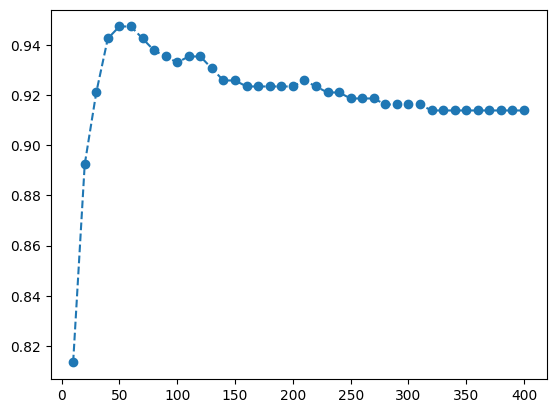

In [355]:
from matplotlib import pyplot as plt
plt.plot([i[0] for i in curve_list], [i[1] for i in curve_list], 'o--')

In [356]:
max([i[1] for i in curve_list])

0.9473684210526315

In [352]:
true_cnt, false_cnt = 0, 0
for idx in range(0, 891):
    output = model(titanic[idx][0])
    if parse_output(output) == parse_output(titanic[idx][1]):
        true_cnt += 1
    else:
        false_cnt += 1

true_cnt, false_cnt, true_cnt/(true_cnt+false_cnt)

(732, 159, 0.8215488215488216)

In [236]:
df1 = pd.read_csv('./test.csv')
df2 = pd.read_csv('./gender_submission.csv')
test = pd.concat([df1, df2['Survived']], axis=1)
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [234]:
df2['Survived']

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64